In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:21: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 20

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models

"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 8s 738us/step - accuracy: 0.5367 - loss: 0.2481 - val_accuracy: 0.5475 - val_loss: 0.2464
Epoch 2/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 703us/step - accuracy: 0.5477 - loss: 0.2462 - val_accuracy: 0.5535 - val_loss: 0.2453
Epoch 3/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 705us/step - accuracy: 0.5542 - loss: 0.2450 - val_accuracy: 0.5572 - val_loss: 0.2439
Epoch 4/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 697us/step - accuracy: 0.5597 - loss: 0.2435 - val_accuracy: 0.5680 - val_loss: 0.2418
Epoch 5/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - accuracy: 0.5667 - loss: 0.2415 - val_accuracy: 0.5735 - val_loss: 0.2402
Epoch 6/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - accuracy: 0.5749 - loss: 0.2400 - val_accuracy: 0.5784 - val_loss: 0.2381
Epoch 7/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 662us/step - accuracy: 0.5796 - loss: 0.2382 - val_accuracy: 0.5814 - val_loss: 0.2374
Epoch 8/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 665us/step - accuracy: 0.5838 -

In [7]:
print(y_test.shape)

(194775,)


In [8]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step
Ridge Classifier:
Accuracy: 0.5260788088820434
Confusion Matrix:
[[65185 34208]
 [58100 37282]]
Precision: 52.149951042103794
Recall: 39.087039483340675
F1 Score: 44.6833501126612
MSE: 47.39211911179566
RMSE: 68.84193424926094


XGBoost Classifier:
Accuracy: 0.5307508663842896
Confusion Matrix:
[[60510 38883]
 [52515 42867]]
Precision: 52.43669724770642
Recall: 44.942441970183054
F1 Score: 48.40119233114288
MSE: 46.92491336157104
RMSE: 68.50176155513888


LightGBM Classifier:
Accuracy: 0.5264741368245411
Confusion Matrix:
[[62541 36852]
 [55379 40003]]
Precision: 52.04996421833322
Recall: 41.93977899394016
F1 Score: 46.4511109691878
MSE: 47.352586317545885
RMSE: 68.8132155312814


Neural Network:
Accuracy: 0.5060608394301117
Confusion Matrix:
[[50973 48420]
 [47787 47595]]
Precision: 49.5703796281831
Recall: 49.89

In [9]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [10]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [11]:
def update_df_with_asset_performance(df, portfolios, value, hold_days):
    """ Update df by marking assets in portfolios with a specified value starting two days after for a duration. """
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value


# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 1, target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], -1, target_days)




[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


In [12]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [13]:
%reload_ext autoreload
%autoreload 2


In [14]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [15]:
xgb_trade_volume.sum()

6301

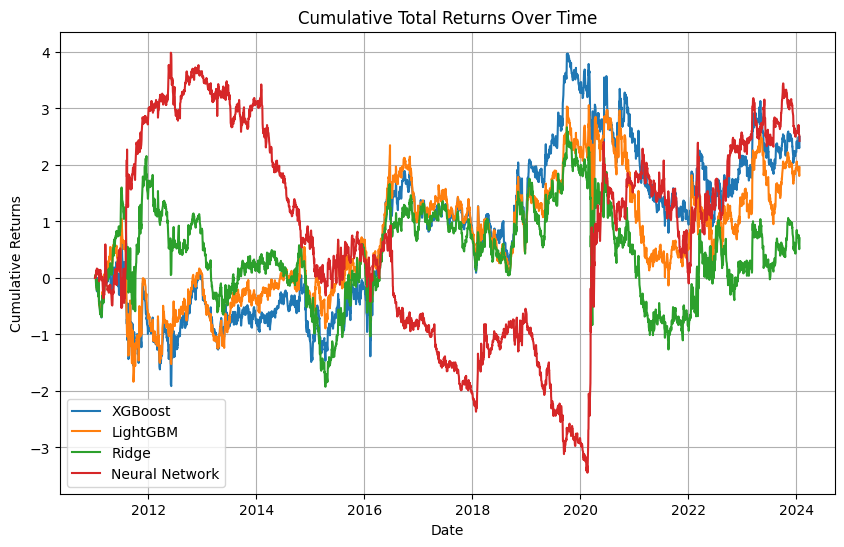

In [16]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = xgb_total_returns.cumsum()
lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [21]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
6301


LightGBM trade volume:
6572


Ridge trade volume:
6423


Neural Network trade volume:
6920




In [18]:
ridge_weights.head(16)

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-07,0,0,0,-1,-1,-1,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-10,0,-1,0,-1,-1,-1,0,0,-1,0,0,0,0,1,1,-1,0,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-11,0,-1,0,-1,-1,-1,0,0,-1,0,0,0,0,1,1,-1,0,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-12,0,-1,0,-1,-1,-1,0,0,-1,0,0,0,0,1,1,-1,1,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-13,0,-1,0,-1,-1,-1,0,0,-1,0,0,0,0,1,1,-1,1,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-14,0,-1,0,-1,-1,-1,0,0,-1,0,0,0,0,1,1,-1,1,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-17,0,-1,0,-1,-1,-1,0,0,-1,0,0,-1,0,1,1,-1,1,-1,0,-1,0,-1,0,0,-1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# alla olika ratios föpr olika portföljer som sharpe osv
# fixa NN
